<a href="https://colab.research.google.com/github/Devininthelab/Toy-Repo/blob/main/Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [3]:
from datasets import load_dataset

dataset = load_dataset('mt_eng_vietnamese', 'iwslt2015-en-vi')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/133318 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1269 [00:00<?, ? examples/s]

In [4]:
dataset['train'][2]

{'translation': {'en': 'I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .',
  'vi': 'Tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .'}}

In [5]:
tokenizer = get_tokenizer("basic_english")

In [6]:
tokens = tokenizer(dataset['train'][0]['translation']['en'])
tokens

['rachel', 'pike', 'the', 'science', 'behind', 'a', 'climate', 'headline']

In [7]:
# find max length
length_en_sentence = []
length_vn_sentence = []
for sentence in dataset['train']:
    temp = len(tokenizer(sentence['translation']['en']))
    length_en_sentence.append(temp)
    temp = len(tokenizer(sentence['translation']['vi']))
    length_vn_sentence.append(temp)

<Axes: ylabel='Count'>

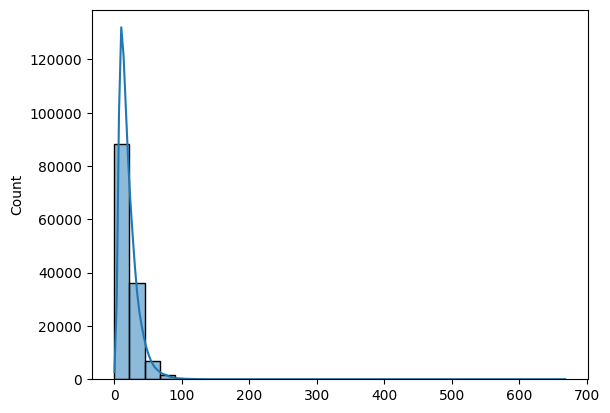

In [8]:
sns.histplot(length_en_sentence, kde=True, bins=30)

<Axes: ylabel='Count'>

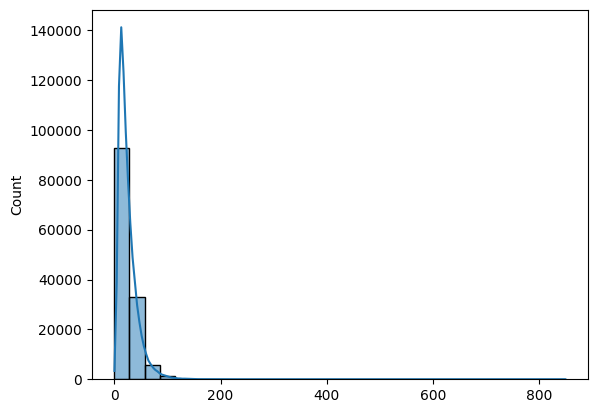

In [9]:
sns.histplot(length_vn_sentence, kde=True, bins=30)

Anyway, use pad sequence so maybe use the max length. Hope it can run :)

### Building vocab

In [10]:
vocab_transform = {}


UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [11]:
dataset['train'][0]

{'translation': {'en': 'Rachel Pike : The science behind a climate headline',
  'vi': 'Khoa học đằng sau một tiêu đề về khí hậu'}}

In [12]:
# Create a function to yield list of tokens
def yield_tokens(data_iter, lang):
    for text in data_iter['translation']:
        yield tokenizer(text[lang])


In [13]:
for lang in ['en', 'vi']:
    train_iter = dataset['train']

    vocab_transform[lang] = build_vocab_from_iterator(
        yield_tokens(train_iter, lang), min_freq=1,
        specials=special_symbols,
        special_first=True
    )

    vocab_transform[lang].set_default_index(UNK_IDX)

In [14]:
print("Length of en vocab", len(vocab_transform['en']))
print("Length of vi vocab", len(vocab_transform['vi']))


Length of en vocab 47271
Length of vi vocab 21114


In [15]:
vocab_transform['en'].get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', ',', '.', 'the', 'and', 'to', '&apos']

In [16]:
vocab_transform['vi'].get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', ',', '.', 'và', 'tôi', 'là', 'một']

# Dataloader

In [17]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func


# function to add SOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))


# Composing
# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for lang in ['en', 'vi']:
    text_transform[lang] = sequential_transforms(
        tokenizer, # Tokenization
        vocab_transform[lang], # Numericalization
        tensor_transform # Add SOS/EOS and create tensor
    )

# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for sample in batch:
        src_sample, tgt_sample = sample['en'], sample['vi']
        src_batch.append(text_transform['en'](src_sample).to(dtype=torch.int64))
        tgt_batch.append(text_transform['vi'](tgt_sample).to(dtype=torch.int64))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

In [18]:
BATCH_SIZE = 8

train_dataloader = DataLoader(
    dataset['train']['translation'],
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

valid_dataloader = DataLoader(
    dataset['validation']['translation'],
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

test_dataloader = DataLoader(
    dataset['test']['translation'],
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

In [19]:
next(iter(train_dataloader))

(tensor([[    2,  6429, 17576,     6,   295,   553,    11,   682,  5334,     3,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1],
         [    2,    14,  1305,   448,     4,  8275,  6115,  6429, 17576,  3285,
             11,  4163,    10,     6,  1267,   896,  1454,   553,     6,  2677,
           3579,    30,   682,   165,     4,    31,   138,   562,    33,    45,
             10,   513,    71,  5174,    33,   444,    11,  5245,  1767,   127,
              6,  3748,    14,  3690,    10,   214,    30,    11,   716,  1426,
              5,     3],
         [    2,    13,     9,   151,    49,     8,   156,     8,    16,   158,
             36,     6,   725,    10,     6,   896,  1454,    12,   33

In [20]:
next(iter(valid_dataloader))

(tensor([[    2,    57,    13,    25,   121,     4,    13,   183,    43,   252,
             25,     6,   275,    30,     6,   478,     4,     7,    13,   984,
             68,  1960,    11,   941,   159,    22,   358,     8,  6827,     5,
             22,     3,     1,     1,     1,     1,     1,     1,     1,     1],
         [    2,     7,    13,    25,    62,  1774,     5,     3,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
         [    2,    14,   219,     4,    17,   592,    11,   136,    10,    88,
           1451,     6,   405,    10,  7120,     0,     4,    29,    17,   186,
            465,   114,    36,     6,   532,    84,     4,  1128,    12,   531,
              4,   675,  3316,     4,  1565,    26,     6,  4603,     5,     3],
         [    2,  1265,    13,   365,

In [21]:
next(iter(test_dataloader))

(tensor([[    2,    57,    13,    25,   121,     4,    13,   183,    43,   252,
             25,     6,   275,    30,     6,   478,     4,     7,    13,   984,
             68,  1960,    11,   941,   159,    22,   358,     8,  6827,     5,
             22,     3,     1,     1,     1,     1,     1,     1,     1,     1],
         [    2,     7,    13,    25,    62,  1774,     5,     3,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
         [    2,    14,   219,     4,    17,   592,    11,   136,    10,    88,
           1451,     6,   405,    10,  7120,     0,     4,    29,    17,   186,
            465,   114,    36,     6,   532,    84,     4,  1128,    12,   531,
              4,   675,  3316,     4,  1565,    26,     6,  4603,     5,     3],
         [    2,  1265,    13,   365,

# Model

Positional Encoding:
$$
\ PE_{(pos, 2i)} = sin(\frac{pos}{1000^{(2i/d_{model})}})\\
\ PE_{(pos, 2i+1)} = cos(\frac{pos}{1000^{(2i/d_{model})}})
$$

In [22]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_seq_len=5000):
        super().__init__()
        self.embed_dim = embed_dim

        pe = torch.zeros(max_seq_len, embed_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim)) #e^ln(x) = x

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x


In [23]:
#helper Module to convert Tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.embed_dim = embed_dim

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.embed_dim) # *sqrt(embed_dim) for better training, kinda normalize

In [24]:
class Seq2Seq(nn.Module):
    def __init__(self, num_encoder_layers,
                num_decoder_layers,
                 embed_dim,
                 nhead,
                 src_vocab_size,
                 tgt_vocab_size,
                 dim_feedforward=512,
                 dropout=0.1):
        super().__init__()
        self.transformer = nn.Transformer(d_model=embed_dim,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout,
                                          batch_first=True)
        self.generator = nn.Linear(embed_dim, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, embed_dim)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(
            embed_dim)

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    # for case specific
    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [25]:
def generate_square_subsequent_mask(max_seq_len):
    mask = (torch.triu(torch.ones((max_seq_len, max_seq_len), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [26]:
def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [27]:
SRC_VOCAB_SIZE = len(vocab_transform['en'])
TGT_VOCAB_SIZE = len(vocab_transform['vi'])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2Seq(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [28]:
src_ids, tgt_ids = next(iter(train_dataloader))
src_ids = src_ids.to(DEVICE)
tgt_ids = tgt_ids.to(DEVICE)
tgt_input = tgt_ids[:, :-1]
tgt_output = tgt_ids[:, 1:]
src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src_ids, tgt_input)
logits = transformer(
    src_ids, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask
)
loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [29]:
logits.shape

torch.Size([8, 77, 21114])

In [30]:
loss

tensor(10.0826, device='cuda:0', grad_fn=<NllLossBackward0>)

# Trainer

In [31]:
device = DEVICE

In [32]:
def train_epoch(model, optimizer, criterion, train_dataloader, device):
    model.train()
    losses = []

    for src_ids, tgt_ids in train_dataloader:
        src_ids = src_ids.to(device) # put into encoder
        tgt_ids = tgt_ids.to(device) # put into decoder

        tgt_input = tgt_ids[:, :-1] #input of decoder
        tgt_output = tgt_ids[:, 1:] #labels of decoder

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src_ids, tgt_input)
        try:
            output = model(
                src_ids, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask
            )
        except:
            print(src_ids.shape, tgt_input.shape)

        optimizer.zero_grad()

        loss = criterion(
            output.reshape(-1, output.shape[-1]),
            tgt_output.reshape(-1))
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

    return sum(losses) / len(losses)

def evaluate(model, data_loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for src_ids, tgt_ids in data_loader:
            src_ids = src_ids.to(device)
            tgt_ids = tgt_ids.to(device)

            tgt_input = tgt_ids[:, :-1]
            tgt_output = tgt_ids[:, 1:]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src_ids, tgt_input)
            output = model(
                src_ids, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask
            )
            loss = criterion(
                output.reshape(-1, output.shape[-1]),
                tgt_output.reshape(-1)
            )
            losses.append(loss.item())
    return sum(losses) / len(losses)

def train(model, train_dataloader, valid_dataloader, optimizer, criterion, device, epochs):
    for epoch in range(1, epochs+1):
        start_time = time.time()
        train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device)
        valid_loss = evaluate(model, valid_dataloader, criterion, device)
        end_time = time.time()
        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

## Training

In [34]:
SRC_VOCAB_SIZE = len(vocab_transform['en'])
TGT_VOCAB_SIZE = len(vocab_transform['vi'])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2Seq(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
transformer = transformer.to(DEVICE)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

epochs = 5
train(transformer, train_dataloader, valid_dataloader, optimizer, criterion, DEVICE, epochs)

Epoch: 1, Train loss: 4.548, Val loss: 4.142, Epoch time = 783.118s
Epoch: 2, Train loss: 3.914, Val loss: 3.846, Epoch time = 779.597s
Epoch: 3, Train loss: 3.670, Val loss: 3.683, Epoch time = 781.584s
Epoch: 4, Train loss: 3.509, Val loss: 3.587, Epoch time = 777.938s
Epoch: 5, Train loss: 3.392, Val loss: 3.505, Epoch time = 813.389s


In [39]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word[-1].item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform['en'](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=SOS_IDX).flatten()
    return " ".join(
        vocab_transform['vi'].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<sos>", "").replace("<eos>", "")

In [40]:
print(translate(transformer, "Hello, My name is Devin and I am from Vietnam."))

 tôi là tên tôi , và tên tôi là tên tôi là tên tôi . 


Tôi tên là tao tôi tên tao tao tên tôi ????:))))

In [41]:
print(translate(transformer, "i go to school"))

 tôi đi học . 


In [43]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.7 MB/s eta 0:00:00


In [44]:
from tqdm import tqdm
import sacrebleu

pred_sentences, tgt_sentences = [], []
for sample in tqdm(dataset['test']['translation']):
    src_sentence = sample['en']
    tgt_sentence = sample['vi']

    pred_sentence = translate(transformer, src_sentence)
    pred_sentences.append(pred_sentence)

    tgt_sentences.append(tgt_sentence)

bleu_score = sacrebleu.corpus_bleu(pred_sentences, [tgt_sentences], force=True)
bleu_score

100%|██████████| 1269/1269 [02:47<00:00,  7.56it/s]


BLEU = 7.46 44.6/16.2/6.1/2.4 (BP = 0.738 ratio = 0.767 hyp_len = 25870 ref_len = 33738)